I'm running a few sets of chains that are fitting the redMagic HOD to a shuffled SHAM, as well as SHAMs with assembly bias to see what happens. I want all the tests I want to do to be in one place. This notebook will do the following:
* Load the chain and plot the contours
* Calculate the MAP values
* Load the original HOD and clustering for the SHAM sample of interest. 
* Populate the halo catalog and calculate its clustering.
* Plot the best fit clustering against the clustering in the fit
* Plot the best fit HOD to the true HOD of the sample

In [125]:
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()

In [126]:
import numpy as np
from chainconsumer import ChainConsumer

In [127]:
from astropy.table import Table
from halotools.utils.table_utils import compute_conditional_percentiles
from halotools.mock_observables import hod_from_mock, wp, tpcf
from pearce.mocks import cat_dict
from pearce.mocks.customHODModels import *
from math import ceil

In [128]:
#fname = '/u/ki/swmclau2/des/PearceMCMC/100_walkers_1000_steps_chain_shuffled_sham_3.npy'
fname = '/u/ki/swmclau2/des/PearceMCMC/200_walkers_5000_steps_chain_shuffled_sham2.npy'

In [129]:
chain = np.loadtxt(fname )

In [130]:
chain.shape

(556800, 5)

In [131]:
n_walkers = 200
n_burn = 1500
n_params = chain.shape[1]

In [132]:
chain = chain[n_burn*n_walkers:, :]

In [133]:
chain.shape

(256800, 5)

In [134]:
param_names = [r'$\log{M_{min}}$', r'$\log{M_0}$',r'$\sigma_{log{M}}$', r'$\log{M_1}$', r'$\alpha$']
#param_names = [r'$f_{sat}$',r'$\mathcal{A}_{sat}$',r'$f_{cen}$', r'$\mathcal{A}_{cen}$']
#param_names = [r'$\mathcal{A}_{sat}$',r'$\mathcal{A}_{cen}$']

In [135]:
c = ChainConsumer()
c.add_chain(chain, parameters=param_names, walkers=n_walkers)
#c.configure(statistics='cumulative')

In [136]:
gelman_rubin_converged = c.diagnostic.gelman_rubin()
print gelman_rubin_converged

Gelman-Rubin Statistic values for chain 0
$\log{M_{min}}$: 1.00172 (Passed)
$\log{M_0}$: 1.00132 (Passed)
$\sigma_{log{M}}$: 1.00170 (Passed)
$\log{M_1}$: 1.00127 (Passed)
$\alpha$: 1.00162 (Passed)
True


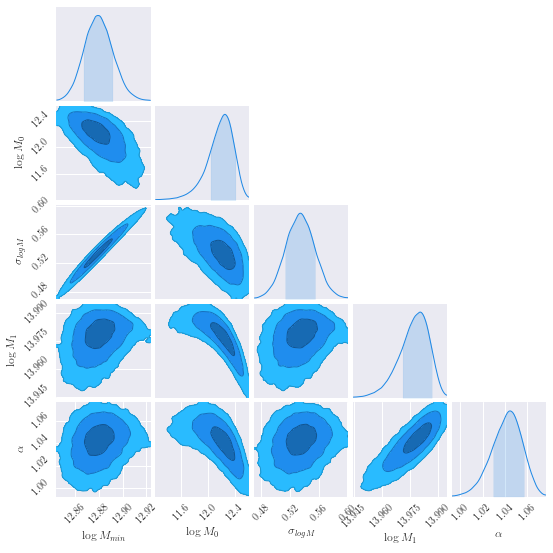

In [137]:
fig = c.plotter.plot(figsize=(8,8), parameters=param_names)
fig.show()

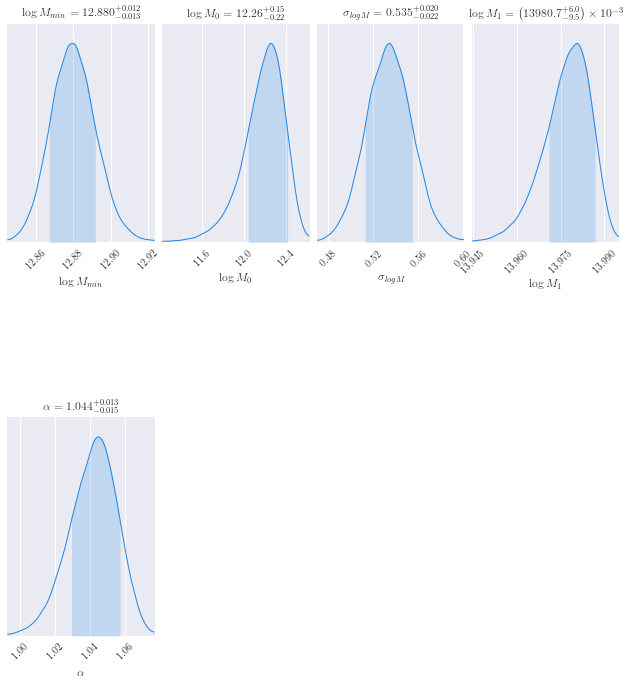

In [138]:
fig = c.plotter.plot_distributions(figsize=(10,10) )
fig.show()

In [139]:
summary  = c.analysis.get_summary()
MAP = np.array([summary[p][1] for p in param_names])
print MAP

[ 12.87976432  12.25908226   0.53478574  13.98067205   1.04428167]


In [140]:
PMASS = 591421440.0000001 #chinchilla 400/ 2048

halo_catalog = Table.read('/u/ki/swmclau2/des/AB_tests/abmatched_halos.hdf5', format = 'hdf5')

In [141]:
shuffle_type = 'sh_shuffled'
mag_type = 'vpeak'
mag_key = 'halo_%s_%s_mag'%(shuffle_type, mag_type)
upid_key = 'halo_%s_upid'%shuffle_type

#mag_key = 'halo%s_%s_mag'%(shuffle_type, mag_type)
#upid_key = 'halo%s_upid'%shuffle_type

In [142]:
cosmo_params = {'simname':'chinchilla', 'Lbox':400.0, 'scale_factors':[0.658, 1.0]}
cat = cat_dict[cosmo_params['simname']](**cosmo_params)#construct the specified catalog!

cat.load_catalog(1.0)
#cat.h = 1.0

In [143]:
mag_cut = -21
min_ptcl = 200

halo_catalog = halo_catalog[halo_catalog['halo_mvir'] > min_ptcl*cat.pmass] #mass cut
galaxy_catalog = halo_catalog[ halo_catalog[mag_key] < mag_cut ] # mag cut

In [144]:
def compute_mass_bins(prim_haloprop, dlog10_prim_haloprop=0.1):   
    lg10_min_prim_haloprop = np.log10(np.min(prim_haloprop))-0.001
    lg10_max_prim_haloprop = np.log10(np.max(prim_haloprop))+0.001
    num_prim_haloprop_bins = (lg10_max_prim_haloprop-lg10_min_prim_haloprop)/dlog10_prim_haloprop
    return np.logspace(
        lg10_min_prim_haloprop, lg10_max_prim_haloprop,
        num=int(ceil(num_prim_haloprop_bins)))

In [145]:
mass_bins = compute_mass_bins(halo_catalog['halo_mvir'], 0.2)
mass_bin_centers = (mass_bins[1:]+mass_bins[:-1])/2.0
#mass_bin_centers = 10**((np.log10(mass_bins[1:])+np.log10(mass_bins[:-1]))/2.0)

In [146]:
cen_mask = galaxy_catalog['halo_upid']==-1
mass_key = 'halo_mvir_host_halo'#
#mass_key = 'halo_%s_host_mvir'%shuffle_type
cen_hod_sham, _ = hod_from_mock(galaxy_catalog[cen_mask][mass_key],\
                        halo_catalog['halo_mvir'],\
                        mass_bins)

sat_hod_sham, _ = hod_from_mock(galaxy_catalog[~cen_mask][mass_key],\
                        halo_catalog['halo_mvir'],\
                        mass_bins)

In [147]:
np.savetxt('/nfs/slac/g/ki/ki18/des/swmclau2/AB_tests/cen_hod.npy', cen_hod_sham)
np.savetxt('/nfs/slac/g/ki/ki18/des/swmclau2/AB_tests/sat_hod.npy', sat_hod_sham)
np.savetxt('/nfs/slac/g/ki/ki18/des/swmclau2/AB_tests/mbc.npy', mass_bin_centers)

In [148]:
training_dir = '/u/ki/swmclau2/des/PearceLHC_wp_z_sham_free_split_no_rsd/'

In [149]:
#rp_bins = np.loadtxt('/nfs/slac/g/ki/ki18/des/swmclau2/AB_tests/rp_bins.npy')
#rp_bins = np.loadtxt('/nfs/slac/g/ki/ki18/des/swmclau2/AB_tests/rpoints.npy')
rp_bins = np.loadtxt(training_dir+'a_1.00000/global_file.npy')

#rp_bins = np.logspace(-1.1, 1.6, 16)
#rpoints =  np.loadtxt('/nfs/slac/g/ki/ki18/des/swmclau2/AB_tests/rpoints.npy')
rpoints = (rp_bins[1:]+rp_bins[:-1])/2.0

#wp_sham = np.log10(np.loadtxt('/nfs/slac/g/ki/ki18/des/swmclau2/AB_tests/sham_%s%s_wp.npy'%(mag_type, shuffle_type)))

In [150]:
#np.savetxt('/nfs/slac/g/ki/ki18/des/swmclau2/AB_tests/rp_bins.npy', rp_bins)

In [151]:
cat.load_model(1.0, HOD='redMagic')
#cat.load_model(1.0, HOD=(FSAssembiasTabulatedCens, FSAssembiasTabulatedSats), hod_kwargs = {'prim_haloprop_vals': mass_bin_centers,
#cat.load_model(1.0, HOD=(HSAssembiasTabulatedCens, HSAssembiasTabulatedSats), hod_kwargs = {'prim_haloprop_vals': mass_bin_centers,
                                                               #'sec_haloprop_key': 'halo_%s'%(mag_type),
#                                                               'cen_hod_vals':cen_hod_sham,
#                                                               'sat_hod_vals':sat_hod_sham})

In [152]:
cat.model.param_dict

{'alpha': 1.02,
 'f_c': 0.19,
 'logM0': 12.2,
 'logM1': 13.7,
 'logMmin': 12.1,
 'sigma_logM': 0.46}

In [153]:
#summary  = c.analysis.get_summary()
MAP = np.array([summary[p][1] for p in param_names])
#MAP = np.zeros((len(param_names),))
#MAP = chain[np.random.randint(chain.shape[0]), :]
print MAP

[ 12.87976432  12.25908226   0.53478574  13.98067205   1.04428167]


In [154]:
param_names

['$\\log{M_{min}}$',
 '$\\log{M_0}$',
 '$\\sigma_{log{M}}$',
 '$\\log{M_1}$',
 '$\\alpha$']

In [155]:
#names = ['mean_occupation_satellites_assembias_split1','mean_occupation_satellites_assembias_param1',
#          'mean_occupation_centrals_assembias_split1', 'mean_occupation_centrals_assembias_param1']
names = ['logMmin','logM0','sigma_logM', 'logM1', 'alpha']
#names = ['mean_occupation_satellites_assembias_param1', 'mean_occupation_centrals_assembias_param1']

In [156]:
params = dict(zip(names, MAP))
params['f_c'] = 1.0
cat.populated_once = False
cat.populate(params)

In [157]:
cat.model.param_dict

{'alpha': 1.0442816697919364,
 'f_c': 1.0,
 'logM0': 12.259082263028743,
 'logM1': 13.980672047624386,
 'logMmin': 12.879764324511683,
 'sigma_logM': 0.53478573565018805}

In [158]:
cen_mask = cat.model.mock.galaxy_table['gal_type']=='centrals'
cen_hod_mock, _ = hod_from_mock(cat.model.mock.galaxy_table[cen_mask]['halo_mvir'],\
                        halo_catalog['halo_mvir'],\
                        mass_bins)

sat_hod_mock, _ = hod_from_mock(cat.model.mock.galaxy_table[~cen_mask]['halo_mvir'],\
                        halo_catalog['halo_mvir'],\
                        mass_bins)

In [159]:
wp_hod = cat.calc_wp(rp_bins, pi_max = 40, do_jackknife=False, RSD=False)
print wp_hod
#wp_hod = cat.calc_xi(rp_bins, do_jackknife=False)

[  7.13525587e+02   4.80977957e+02   3.22201889e+02   2.25904936e+02
   1.48594007e+02   9.85173680e+01   7.10957886e+01   5.55579857e+01
   4.28059778e+01   3.43638495e+01   2.60890524e+01   1.95505824e+01
   1.39005375e+01   9.62958514e+00   6.59001611e+00   3.95429222e+00
   2.06023233e+00   6.75436035e-01]


In [160]:
from halotools.mock_observables import return_xyz_formatted_array

In [161]:
sham_pos = np.c_[galaxy_catalog['halo_%s_x'%shuffle_type],\
                 galaxy_catalog['halo_%s_y'%shuffle_type],\
                 galaxy_catalog['halo_%s_z'%shuffle_type]]

wp_sham = wp(sham_pos*cat.h, rp_bins, 40.0*cat.h, period=cat.Lbox*cat.h, num_threads=1)
print wp_sham
#wp_sham = tpcf(sham_pos*h, rp_bins, period=400.0*h, num_threads=1)

#wp_sham = np.log10(wp(sham_pos, rp_bins, 40.0, period=400.0, num_threads=1))

[ 680.02597961  482.03814319  330.49916148  220.17755641  152.15543255
  104.54368491   74.39001391   54.9294766    41.95007851   33.46941948
   25.74436115   19.51383558   14.07818953    9.81179239    6.67297334
    3.87212065    1.90182268    0.69192131]


In [162]:
#np.savetxt('/nfs/slac/g/ki/ki18/des/swmclau2/AB_tests/sham_%s_%s_wp.npy'%(mag_type, shuffle_type), wp_sham)
#np.savetxt('/nfs/slac/g/ki/ki18/des/swmclau2/AB_tests/sham_vpeak_shuffled_nd.npy',np.array([cat.calc_analytic_nd()]) )

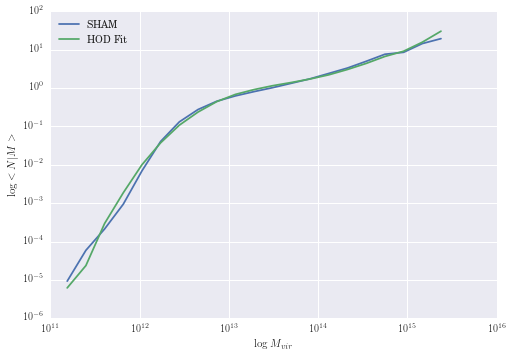

In [163]:
plt.plot(mass_bin_centers, cen_hod_sham+sat_hod_sham, label = 'SHAM')
plt.plot(mass_bin_centers, cen_hod_mock+sat_hod_mock, label = 'HOD Fit')
plt.legend(loc='best')
plt.xlabel(r"$\log{M_{vir}}$")
plt.ylabel(r"$\log{<N|M>}$")
plt.loglog()
plt.show();

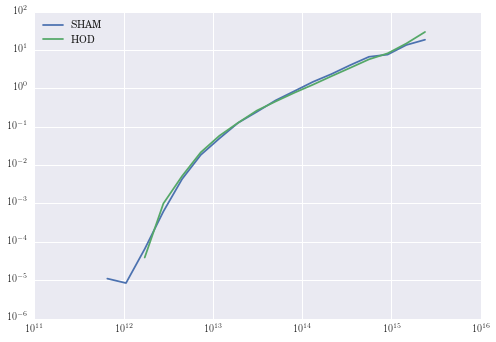

In [164]:
plt.plot(mass_bin_centers, sat_hod_sham, label = 'SHAM')
plt.plot(mass_bin_centers, sat_hod_mock, label = 'HOD')
plt.legend(loc='best')

plt.vlines(PMASS*min_ptcl,0, 100)
plt.loglog()
plt.show();

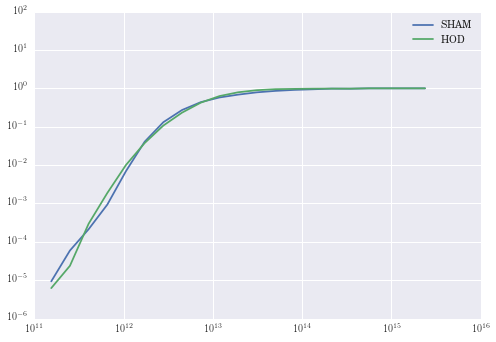

In [165]:
plt.plot(mass_bin_centers, cen_hod_sham, label = 'SHAM')
plt.plot(mass_bin_centers, cen_hod_mock, label = 'HOD')
plt.legend(loc='best')

plt.vlines(PMASS*min_ptcl,0, 100)
plt.loglog()
plt.show();

In [166]:
sham_nd = len(galaxy_catalog)/(cat.Lbox*0.7)**3
hod_nd = cat.calc_analytic_nd()

In [167]:
print sham_nd/hod_nd

1.00208145843


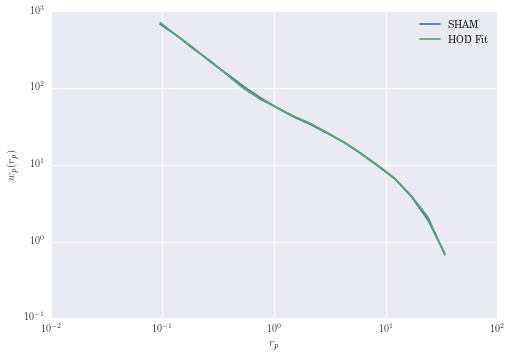

In [168]:
plt.plot(rpoints, wp_sham, label = 'SHAM')
plt.plot(rpoints, wp_hod, label = 'HOD Fit')
plt.loglog()
#plt.xscale('log')
#plt.ylim([-0.2, 3.5])
plt.legend(loc='best')
plt.xlabel(r"$r_p$")
plt.ylabel(r"$w_p(r_p)$")
plt.show()

In [169]:
wp_hod

array([  7.13525587e+02,   4.80977957e+02,   3.22201889e+02,
         2.25904936e+02,   1.48594007e+02,   9.85173680e+01,
         7.10957886e+01,   5.55579857e+01,   4.28059778e+01,
         3.43638495e+01,   2.60890524e+01,   1.95505824e+01,
         1.39005375e+01,   9.62958514e+00,   6.59001611e+00,
         3.95429222e+00,   2.06023233e+00,   6.75436035e-01])

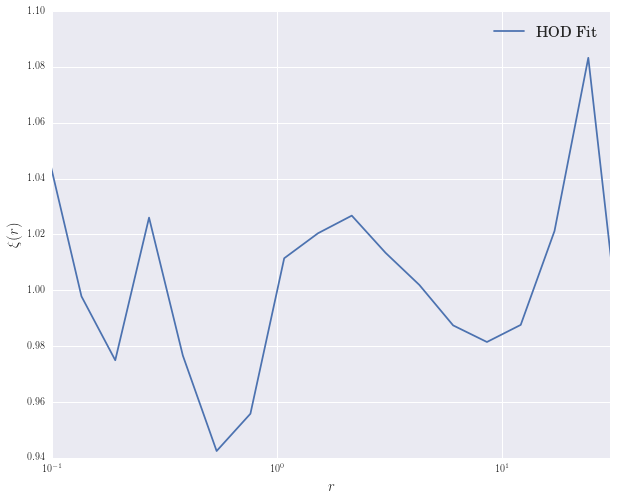

In [170]:
plt.figure(figsize=(10,8))

#plt.plot(rpoints, wp_sham/wp_sham, label = 'SHAM')
plt.plot(rpoints, wp_hod/wp_sham, label = 'HOD Fit')
plt.xscale('log')
plt.legend(loc='best',fontsize = 15)
plt.xlim([1e-1, 30e0]);
#plt.ylim([1,15000])
plt.xlabel(r'$r$',fontsize = 15)
plt.ylabel(r'$\xi(r)$',fontsize = 15)
plt.show()

In [171]:
print wp_sham/wp_hod

[ 0.95305059  1.00220423  1.02575178  0.97464695  1.02396749  1.0611701
  1.04633503  0.98868733  0.98000515  0.97397177  0.9867879   0.99812042
  1.01278023  1.01892161  1.01258832  0.97921965  0.92311078  1.02440686]


In [172]:
print wp_sham
print wp_hod

[ 680.02597961  482.03814319  330.49916148  220.17755641  152.15543255
  104.54368491   74.39001391   54.9294766    41.95007851   33.46941948
   25.74436115   19.51383558   14.07818953    9.81179239    6.67297334
    3.87212065    1.90182268    0.69192131]
[  7.13525587e+02   4.80977957e+02   3.22201889e+02   2.25904936e+02
   1.48594007e+02   9.85173680e+01   7.10957886e+01   5.55579857e+01
   4.28059778e+01   3.43638495e+01   2.60890524e+01   1.95505824e+01
   1.39005375e+01   9.62958514e+00   6.59001611e+00   3.95429222e+00
   2.06023233e+00   6.75436035e-01]


In [173]:
from pearce.emulator import OriginalRecipe, ExtraCrispy

In [174]:
training_dir = '/u/ki/swmclau2/des/PearceLHC_wp_z_sham_emulator_no_rsd/'

em_method = 'gp'
split_method = 'random'

load_fixed_params = {'z':0.0}

emu = ExtraCrispy(training_dir,10, 2, split_method, method=em_method, fixed_params=load_fixed_params)

In [175]:
for n in names:
    print n, emu.get_param_bounds(n)

logMmin (12.5, 13.5)
logM0 (10, 13)
sigma_logM (0.2, 1.0)
logM1 (13.0, 16.0)
alpha (0.75, 1.25)
